In [159]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
# from Bio.Data import CodonTable
# from Bio.Data.CodonTable import NCBICodonTableDNA
# from Bio import SeqIO
from scipy import spatial
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

# from mutspec.annotation import (
#     calculate_mutspec, CodonAnnotation, mutations_summary, 
#     translator, rev_comp, lbl2lbl_id, lbl_id2lbl
# )
from pymutspec.constants import possible_codons, possible_sbs12, possible_sbs192
# from mutspec.io import read_genbank_ref
# from mutspec.draw.mut import plot_mutspec12, plot_mutspec192, plot_mutspec192kk

sns.set_style()

In [160]:
path_to_data = "../data/MutSpecVertebratescytb.csv"
mutspec = pd.read_csv(path_to_data)
print("#species", mutspec.Species.nunique())
print(mutspec.shape)
mutspec.head()

#species 974
(187008, 10)


Species      Mut  Expected  Observed  RawMutSpec  \
0  Abbottina_obtusirostris  T[T>G]T       0.0       0.0         0.0   
1  Abbottina_obtusirostris  G[T>G]T       0.0       0.0         0.0   
2  Abbottina_obtusirostris  C[T>G]T       0.0       0.0         0.0   
3  Abbottina_obtusirostris  A[T>G]T       0.0       0.0         0.0   
4  Abbottina_obtusirostris  T[T>C]T       8.0       0.0         0.0   

   RawMutSpecSum  MutSpec MutBase Context           Class  
0       1.088889      0.0     T>G     TTT  Actinopterygii  
1       1.088889      0.0     T>G     GTT  Actinopterygii  
2       1.088889      0.0     T>G     CTT  Actinopterygii  
3       1.088889      0.0     T>G     ATT  Actinopterygii  
4       1.088889      0.0     T>C     TTT  Actinopterygii

## Drop species with low number of observed mutations!

In [161]:
sp_count = mutspec.groupby("Species").Observed.sum()

MIN_MUT_NUM = 50
mutspec = mutspec[mutspec.Species.isin(sp_count[sp_count > MIN_MUT_NUM].index)]
print("#species", mutspec.Species.nunique())
mutspec.shape[0]

#species 599


115008

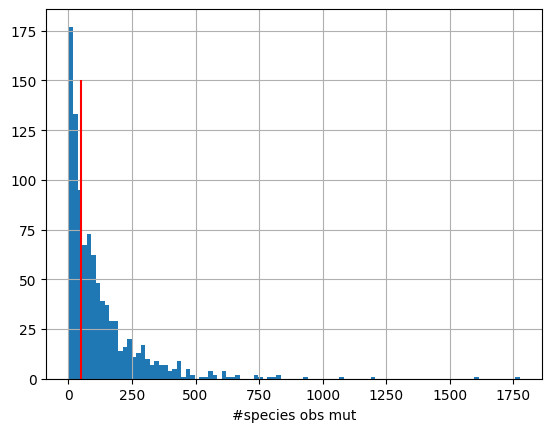

In [162]:
sp_count.hist(bins=100)
plt.xlabel("#species obs mut");
plt.vlines([MIN_MUT_NUM], 0, 150, 'r')

In [163]:
sp2mut = mutspec.pivot(index=["Class", "Species"], columns="Mut", values="MutSpec")
sp2mut = sp2mut[possible_sbs192]
sp2mut.head().round(2)

Mut                                        A[A>C]A  A[A>C]C  A[A>C]G  A[A>C]T  \
Class          Species                                                          
Actinopterygii Abbottina_rivularis            0.00      0.0      0.0      0.0   
               Acanthopagrus_schlegelii       0.01      0.0      0.0      0.0   
               Acheilognathus_macropterus     0.00      0.0      0.0      0.0   
               Acheilognathus_rhombeus        0.00      0.0      0.0      0.0   
               Acheilognathus_signifer        0.01      0.0      0.0      0.0   

Mut                                        C[A>C]A  C[A>C]C  C[A>C]G  C[A>C]T  \
Class          Species                                                          
Actinopterygii Abbottina_rivularis             0.0     0.00     0.00      0.0   
               Acanthopagrus_schlegelii        0.0     0.00     0.01      0.0   
               Acheilognathus_macropterus      0.0     0.00     0.00      0.0   
               Acheilognathus_rhombeus         0.0     0.00     0.00      0.0   
               Acheilognathus_signifer         0.0     0.01     0.00      0.0   

Mut                                        G[A>C]A  G[A>C]C  ...  C[T>G]G  \
Class          Species                                       ...            
Actinopterygii Abbottina_rivularis            0.00      0.0  ...     0.00   
               Acanthopagrus_schlegelii       0.00      0.0  ...     0.01   
               Acheilognathus_macropterus     0.00      0.0  ...     0.00   
               Acheilognathus_rhombeus        0.00      0.0  ...     0.00   
               Acheilognathus_signifer        0.01      0.0  ...     0.00   

Mut                                        C[T>G]T  G[T>G]A  G[T>G]C  G[T>G]G  \
Class          Species                                                          
Actinopterygii Abbottina_rivularis             0.0     0.00      0.0      0.0   
               Acanthopagrus_schlegelii        0.0     0.01      0.0      0.0   
               Acheilognathus_macropterus      0.0     0.00      0.0      0.0   
               Acheilognathus_rhombeus         0.0     0.00      0.0      0.0   
               Acheilognathus_signifer         0.0     0.00      0.0      0.0   

Mut                                        G[T>G]T  T[T>G]A  T[T>G]C  T[T>G]G  \
Class          Species                                                          
Actinopterygii Abbottina_rivularis             0.0      0.0      0.0      0.0   
               Acanthopagrus_schlegelii        0.0      0.0      0.0      0.0   
               Acheilognathus_macropterus      0.0      0.0      0.0      0.0   
               Acheilognathus_rhombeus         0.0      0.0      0.0      0.0   
               Acheilognathus_signifer         0.0      0.0      0.0      0.0   

Mut                                        T[T>G]T  
Class          Species                              
Actinopterygii Abbottina_rivularis             0.0  
               Acanthopagrus_schlegelii        0.0  
               Acheilognathus_macropterus      0.0  
               Acheilognathus_rhombeus         0.0  
               Acheilognathus_signifer         0.0  

[5 rows x 192 columns]

## species clustermap

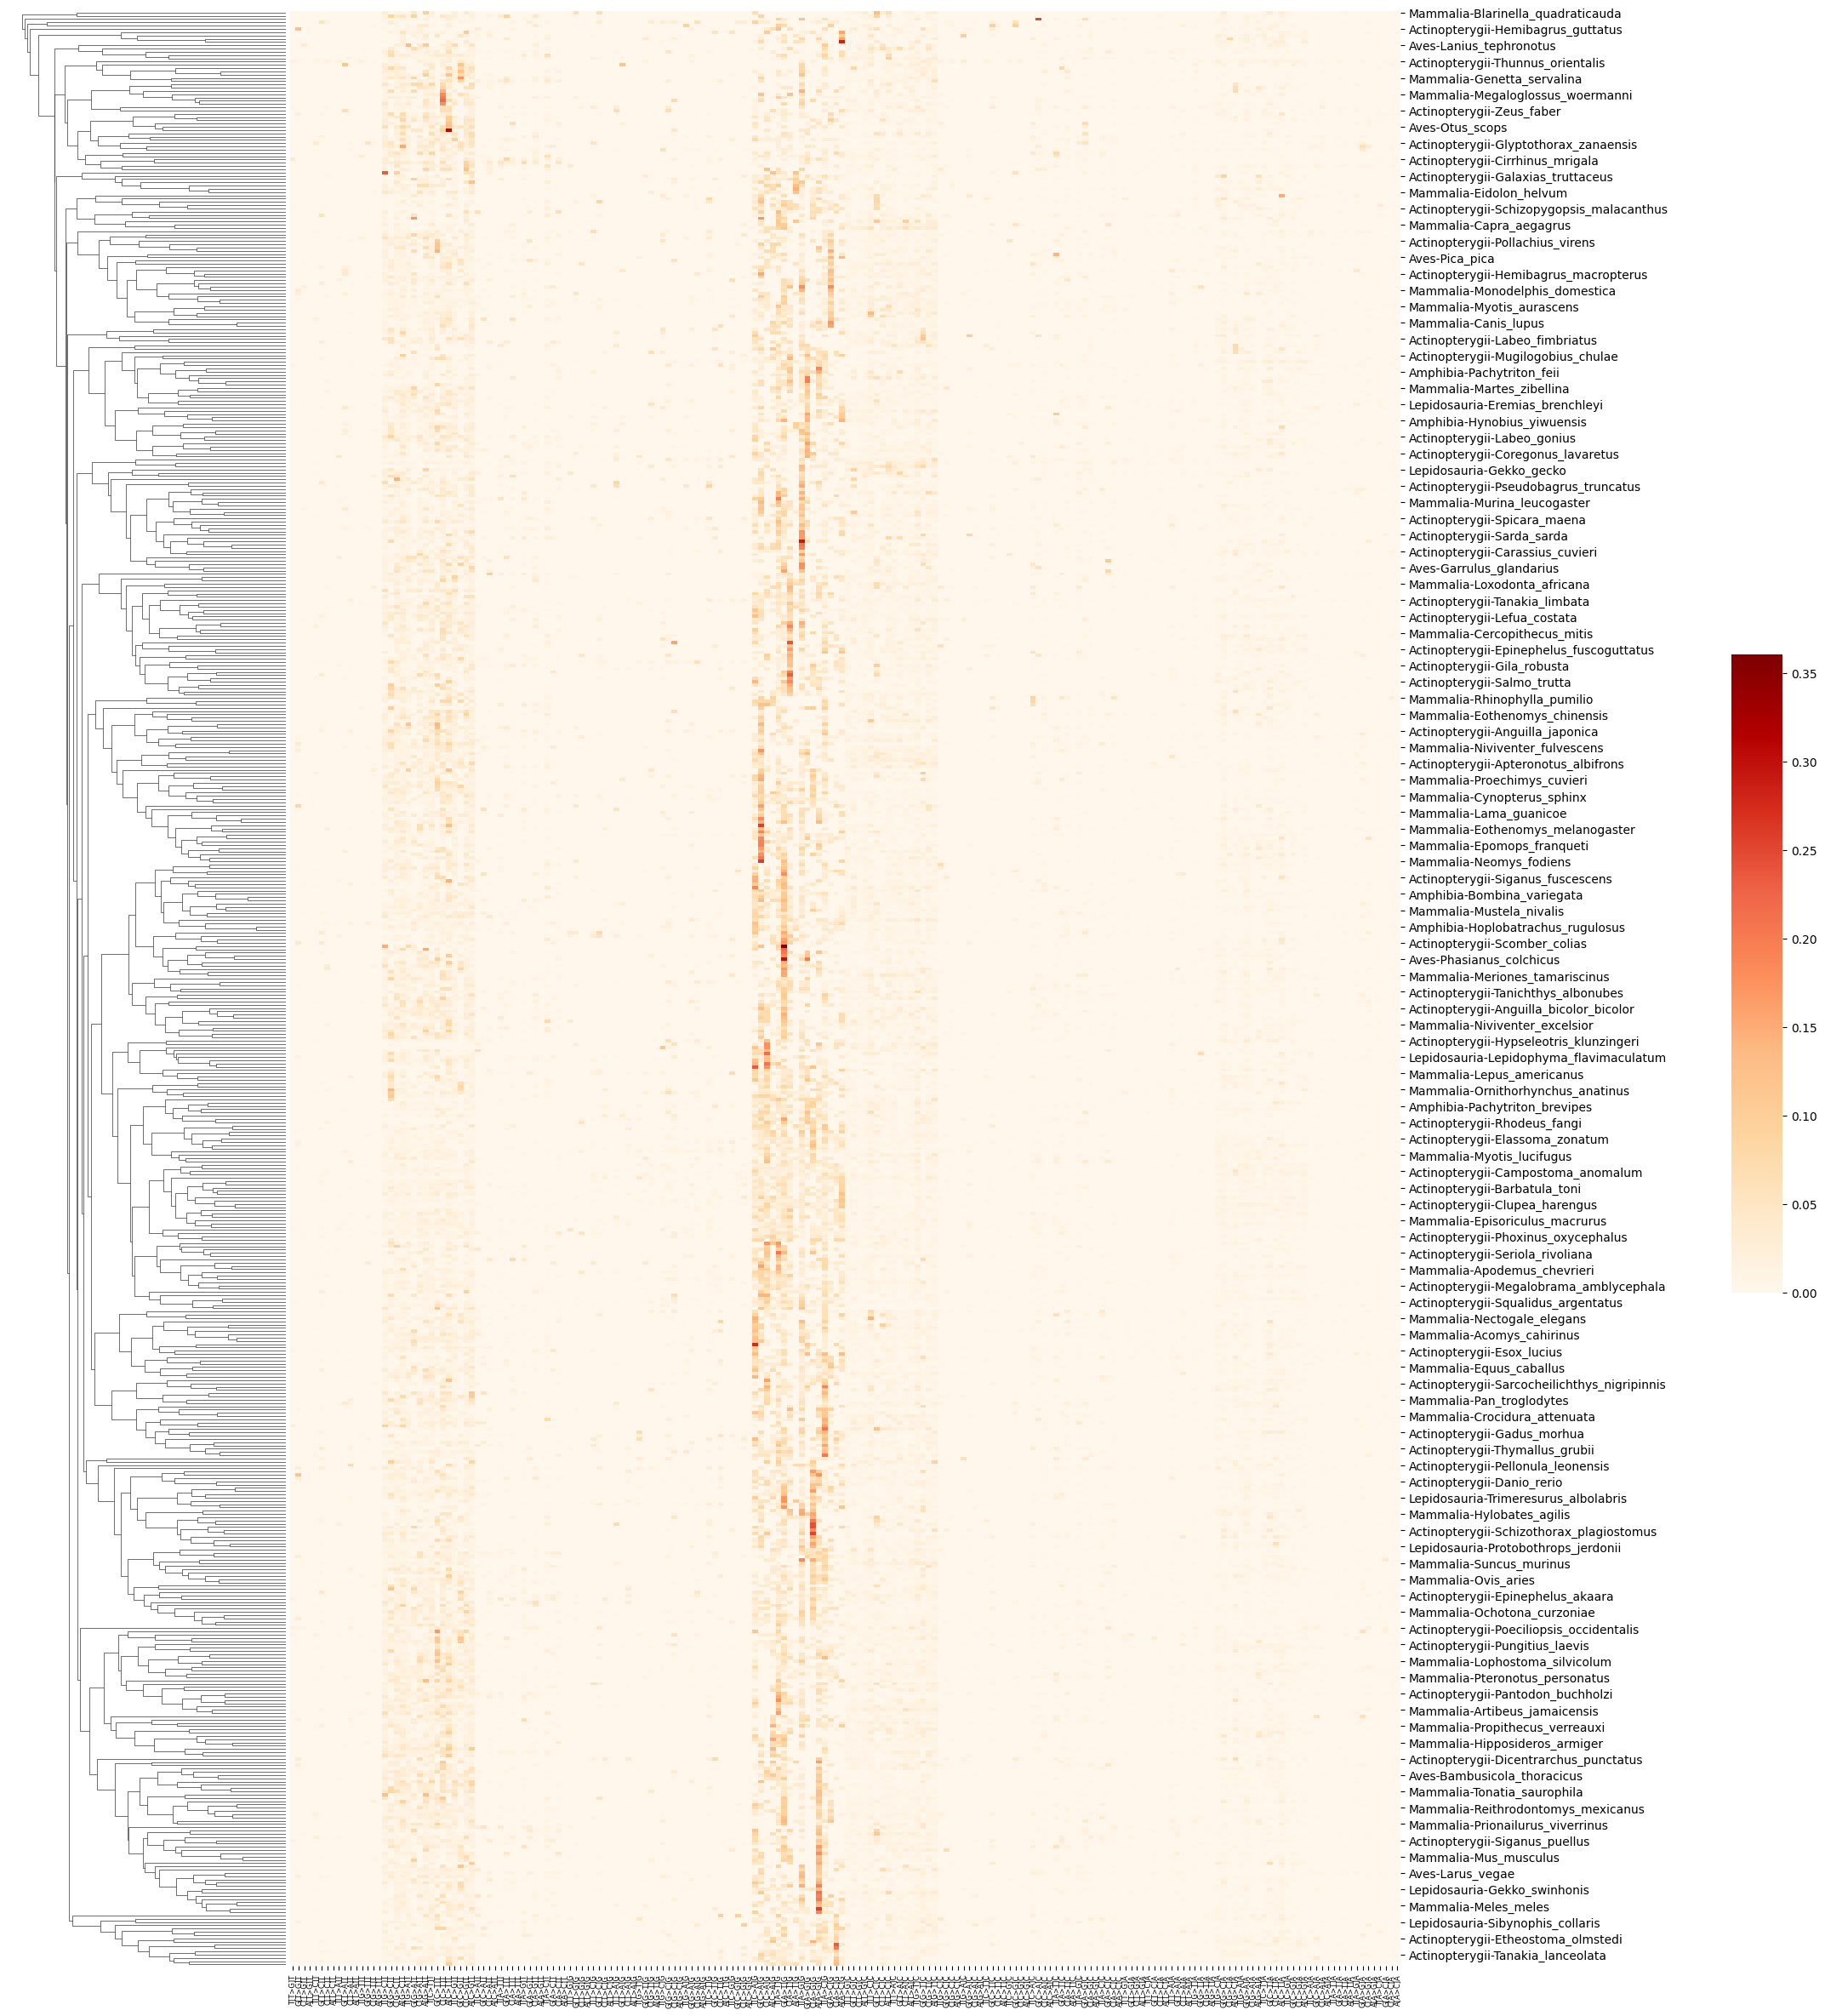

In [64]:
grd = sns.clustermap(
    data=sp2mut, 
    # pivot_kws=dict(index=["Class", "Species"], columns="Mut", values="MutSpec"), 
    col_cluster=False,
    metric=spatial.distance.cosine,
    xticklabels=mutspec.Mut.unique(),
    cmap="OrRd",
    figsize=(20, 30),
    cbar_pos=(1.02, 0.3, 0.03, 0.25),
)
grd.ax_col_dendrogram.remove()
grd.ax_heatmap.set_ylabel("")
grd.ax_heatmap.set_xlabel("")
plt.setp(grd.ax_heatmap.get_xticklabels(), size=6,)
# plt.tight_layout()
# grd.savefig("../pictures/dendromap.pdf")
plt.show()

## Redusing dimensions

### Filter out transversions

In [ ]:
import pymutspec

transitions = [x for x in pymutspec.constants.possible_sbs192 if x[2:5] in {"C>T", "T>C", "A>G", "G>A"}]
len(transitions)

64

In [ ]:
df = df[transitions]

### UMAP & TSNE

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [31]:
pca = PCA()
X_pca = pca.fit_transform(df)
pca.explained_variance_ratio_[:40].sum()

0.9716185192191391

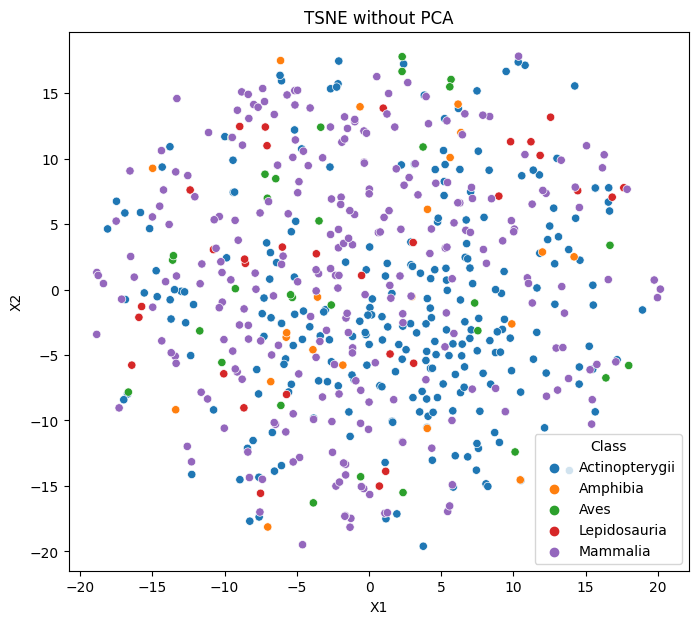

In [32]:
tsne = TSNE(2, n_jobs=12)
X_tsne = tsne.fit_transform(df)

rdf = pd.DataFrame(columns=["X1", "X2"], data=X_tsne)
rdf["Class"] = df.index.get_level_values(0)

fig, ax = plt.subplots()
fig.set_size_inches((8, 7))
sns.scatterplot(data=rdf, x="X1", y="X2", hue="Class", ax=ax)
ax.set_title("TSNE without PCA")
plt.show()

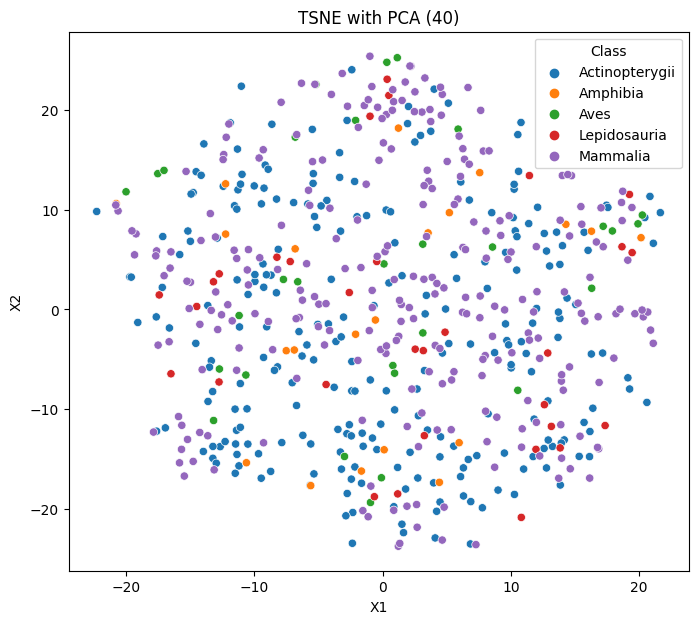

In [34]:
nfea = 40
tsne = TSNE(2, n_jobs=12, metric="cosine")
X_tsne = tsne.fit_transform(X_pca[:, :nfea])

rdf = pd.DataFrame(columns=["X1", "X2"], data=X_tsne)
rdf["Class"] = df.index.get_level_values(0)

fig, ax = plt.subplots()
fig.set_size_inches((8, 7))
sns.scatterplot(data=rdf, x="X1", y="X2", hue="Class", ax=ax)
ax.set_title(f"TSNE with PCA ({nfea})")
plt.show()

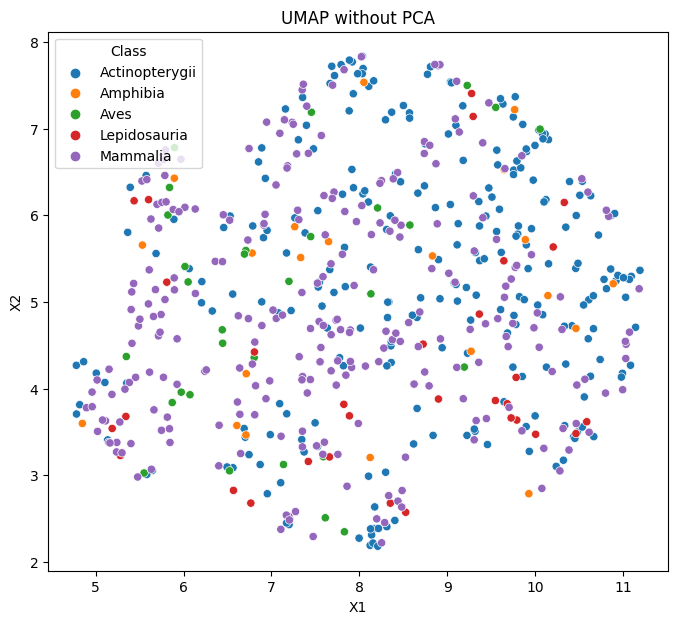

In [35]:
reducer = umap.UMAP(metric="cosine")
X_umap = reducer.fit_transform(df)

rdf = pd.DataFrame(columns=["X1", "X2"], data=X_umap)
rdf["Class"] = df.index.get_level_values(0)

fig, ax = plt.subplots()
fig.set_size_inches((8, 7))
sns.scatterplot(data=rdf, x="X1", y="X2", hue="Class", ax=ax)
ax.set_title(f"UMAP without PCA")
plt.show()

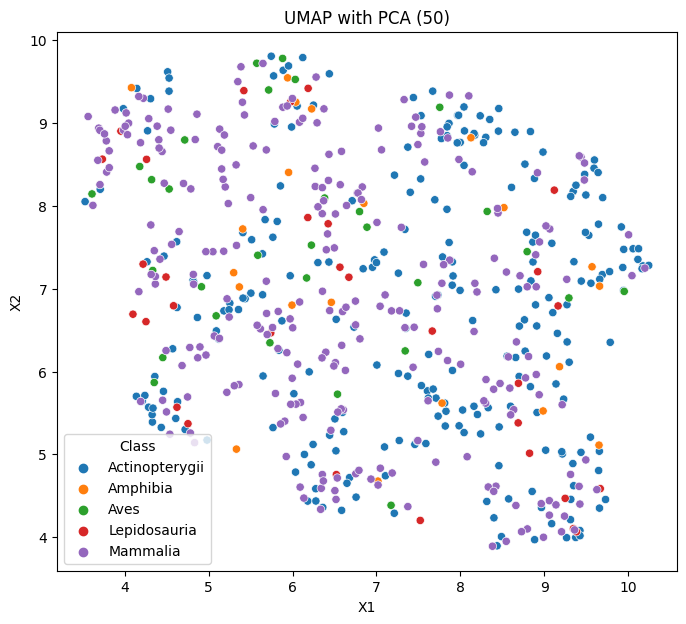

In [37]:
nfea = 50
reducer = umap.UMAP(metric="cosine")
X_umap = reducer.fit_transform(X_pca[:, :nfea])

rdf = pd.DataFrame(columns=["X1", "X2"], data=X_umap)
rdf["Class"] = df.index.get_level_values(0)

fig, ax = plt.subplots()
fig.set_size_inches((8, 7))
sns.scatterplot(data=rdf, x="X1", y="X2", hue="Class", ax=ax)
ax.set_title(f"UMAP with PCA ({nfea})")
plt.show()

## Pairwise species-specific comparison 192

- [link](https://seaborn.pydata.org/generated/seaborn.clustermap.html)
- [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage)
- [link](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)
- [link](https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot)

In [164]:
data = []
cls_order = ['Aves', 'Lepidosauria', 'Amphibia', 'Actinopterygii', 'Mammalia']
for _cls in cls_order:
    print(_cls)
    cls_sp = sp2mut.loc[_cls]
    cls_sp_sim = pd.DataFrame(1 - squareform(pdist(cls_sp, "cosine")), index=cls_sp.index, columns=cls_sp.index)
    dn = dendrogram(linkage(cls_sp_sim), no_plot=True)
    dn["leaves"]
    data.append(cls_sp.iloc[dn["leaves"]].assign(Class=_cls).reset_index().set_index(["Class", "Species"]))

sp2mut_sorted = pd.concat(data)

assert (sp2mut_sorted.sort_index() == sp2mut.sort_index()).all().all()

Aves
Lepidosauria
Amphibia
Actinopterygii
Mammalia


In [165]:
sp2mut_sorted.head()

Mut                       A[A>C]A  A[A>C]C   A[A>C]G  A[A>C]T  C[A>C]A  \
Class Species                                                            
Aves  Gallus_gallus           0.0      0.0  0.000000      0.0      0.0   
      Lanius_tephronotus      0.0      0.0  0.030265      0.0      0.0   
      Anser_cygnoides         0.0      0.0  0.000000      0.0      0.0   
      Regulus_regulus         0.0      0.0  0.000000      0.0      0.0   
      Ithaginis_cruentus      0.0      0.0  0.000000      0.0      0.0   

Mut                       C[A>C]C  C[A>C]G  C[A>C]T   G[A>C]A  G[A>C]C  ...  \
Class Species                                                           ...   
Aves  Gallus_gallus           0.0      0.0      0.0  0.000000      0.0  ...   
      Lanius_tephronotus      0.0      0.0      0.0  0.000000      0.0  ...   
      Anser_cygnoides         0.0      0.0      0.0  0.000000      0.0  ...   
      Regulus_regulus         0.0      0.0      0.0  0.000000      0.0  ...   
      Ithaginis_cruentus      0.0      0.0      0.0  0.010018      0.0  ...   

Mut                        C[T>G]G  C[T>G]T   G[T>G]A  G[T>G]C   G[T>G]G  \
Class Species                                                              
Aves  Gallus_gallus       0.000000      0.0  0.000000      0.0  0.000000   
      Lanius_tephronotus  0.000000      0.0  0.000000      0.0  0.000000   
      Anser_cygnoides     0.000000      0.0  0.000000      0.0  0.000000   
      Regulus_regulus     0.007298      0.0  0.000000      0.0  0.000000   
      Ithaginis_cruentus  0.001670      0.0  0.002004      0.0  0.004007   

Mut                       G[T>G]T   T[T>G]A   T[T>G]C   T[T>G]G  T[T>G]T  
Class Species                                                             
Aves  Gallus_gallus           0.0  0.000000  0.000000  0.000000      0.0  
      Lanius_tephronotus      0.0  0.000000  0.000000  0.000000      0.0  
      Anser_cygnoides         0.0  0.000000  0.000000  0.000000      0.0  
      Regulus_regulus         0.0  0.000000  0.000000  0.000000      0.0  
      Ithaginis_cruentus      0.0  0.003339  0.004007  0.001821      0.0  

[5 rows x 192 columns]

In [166]:
sp_sim = pd.DataFrame(1 - squareform(pdist(sp2mut_sorted, "cosine")), index=sp2mut_sorted.index, columns=sp2mut_sorted.index)
sp_sim.head()

Class                             Aves                                     \
Species                  Gallus_gallus Lanius_tephronotus Anser_cygnoides   
Class Species                                                               
Aves  Gallus_gallus           1.000000           0.084702        0.110283   
      Lanius_tephronotus      0.084702           1.000000        0.367122   
      Anser_cygnoides         0.110283           0.367122        1.000000   
      Regulus_regulus         0.131213           0.361241        0.188561   
      Ithaginis_cruentus      0.496664           0.583216        0.252271   

Class                                                        \
Species                  Regulus_regulus Ithaginis_cruentus   
Class Species                                                 
Aves  Gallus_gallus             0.131213           0.496664   
      Lanius_tephronotus        0.361241           0.583216   
      Anser_cygnoides           0.188561           0.252271   
      Regulus_regulus           1.000000           0.401906   
      Ithaginis_cruentus        0.401906           1.000000   

Class                                                                     \
Species                  Pomatorhinus_ruficollis Henicorhina_leucosticta   
Class Species                                                              
Aves  Gallus_gallus                     0.434964                0.355808   
      Lanius_tephronotus                0.399101                0.600197   
      Anser_cygnoides                   0.215334                0.447416   
      Regulus_regulus                   0.361205                0.471503   
      Ithaginis_cruentus                0.649578                0.596002   

Class                                                         \
Species                  Copsychus_saularis Garrulax_canorus   
Class Species                                                  
Aves  Gallus_gallus                0.227714         0.305465   
      Lanius_tephronotus           0.387738         0.377581   
      Anser_cygnoides              0.458075         0.357833   
      Regulus_regulus              0.388540         0.572007   
      Ithaginis_cruentus           0.462143         0.449044   

Class                                         ...               Mammalia  \
Species                  Ficedula_hyperythra  ... Ailuropoda_melanoleuca   
Class Species                                 ...                          
Aves  Gallus_gallus                 0.259196  ...               0.237289   
      Lanius_tephronotus            0.435577  ...               0.369538   
      Anser_cygnoides               0.364027  ...               0.386721   
      Regulus_regulus               0.406345  ...               0.225727   
      Ithaginis_cruentus            0.534460  ...               0.495276   

Class                                                                         \
Species                  Apodemus_draco Cricetulus_kamensis Ursus_thibetanus   
Class Species                                                                  
Aves  Gallus_gallus            0.406922            0.244275         0.237532   
      Lanius_tephronotus       0.433801            0.470709         0.423092   
      Anser_cygnoides          0.349199            0.386538         0.348501   
      Regulus_regulus          0.276081            0.369700         0.384138   
      Ithaginis_cruentus       0.559295            0.483007         0.452541   

Class                                                                 \
Species                  Ctenomys_sociabilis Leptonychotes_weddellii   
Class Species                                                          
Aves  Gallus_gallus                 0.131694                0.179709   
      Lanius_tephronotus            0.165948                0.204920   
      Anser_cygnoides               0.272392                0.326094   
      Regulus_regulus               0.477980                0.522770   
  

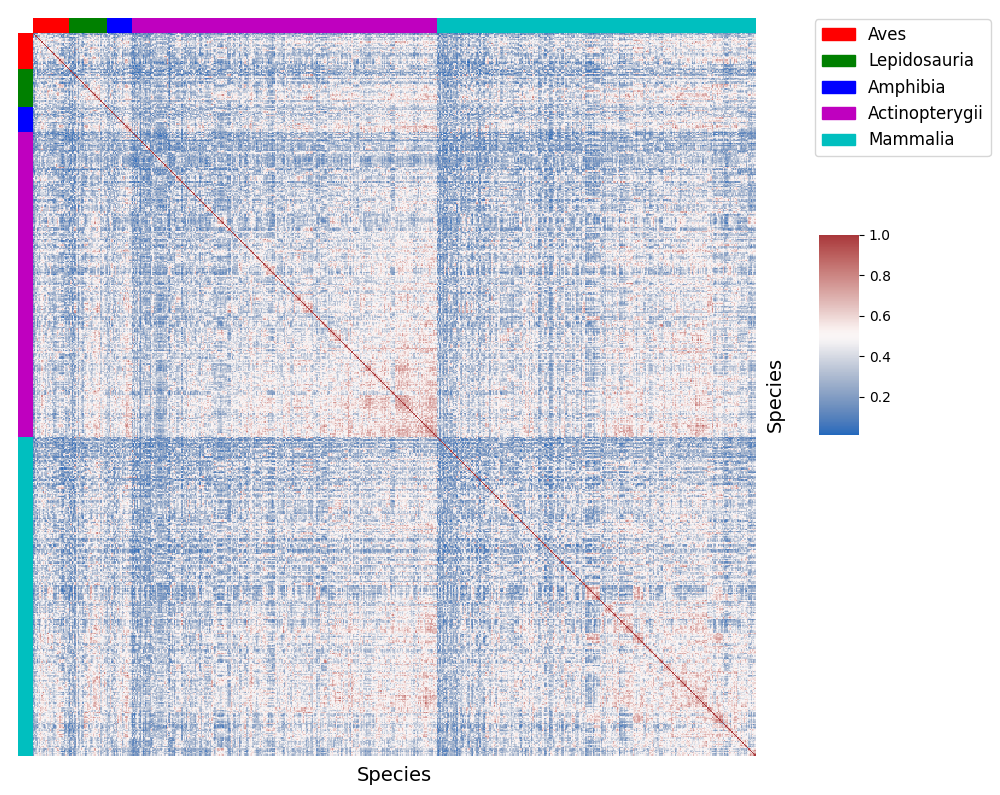

In [133]:
cls_colors = "rgbmc"

g = sns.clustermap(
    sp_sim, 
    cmap="vlag",
    metric="cosine",
    row_cluster=False,
    col_cluster=False,
    row_colors=sp_sim.index.get_level_values(0).map(dict(zip(cls_order, cls_colors))),
    col_colors=sp_sim.index.get_level_values(0).map(dict(zip(cls_order, cls_colors))),
    cbar_pos=(1.03, 0.45, 0.05, 0.25),
    xticklabels=False,
    yticklabels=False,
    figsize=(8, 8),
    dendrogram_ratio=0.01,
    colors_ratio=0.02,
)

g.ax_heatmap.set_xlabel("Species", fontsize=14)
g.ax_heatmap.set_ylabel("Species", fontsize=14)

patches = [mpatches.Patch(color=clr, label=c) for clr, c in zip(cls_colors, cls_order)]

plt.legend(handles=patches, fontsize=12, bbox_to_anchor=(4.5, 2.12))


plt.savefig("../pictures/species_pairwise_similarity.png", bbox_inches="tight")
plt.show()

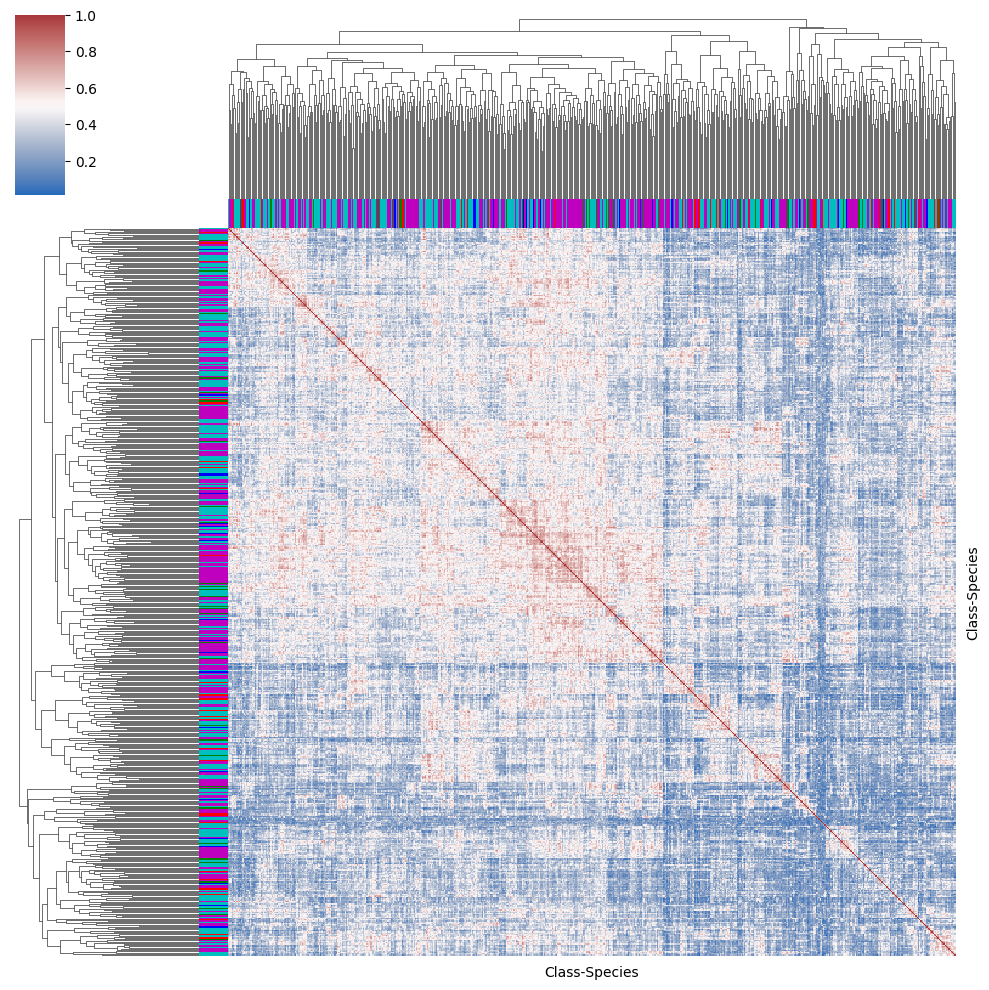

In [16]:
cls_colors = "rgbmc"

sns.clustermap(
    sp_sim, cmap="vlag", 
    row_colors=sp_sim.index.get_level_values(0).map(dict(zip(cls_order, cls_colors))),
    col_colors=sp_sim.index.get_level_values(0).map(dict(zip(cls_order, cls_colors))),
    xticklabels=False,
    yticklabels=False,
);

Cannot see class similarities

In [247]:
data = []
for cl1 in sp_sim.index.levels[0]:
    for cl2 in sp_sim.index.levels[0]:
        if cl1 == cl2:
            cur_sims = 1 - pdist(sp2mut.loc[cl1, possible_sbs192], "cosine")
        else:
            cur_sims = 1 - cdist(sp2mut.loc[cl1, possible_sbs192], sp2mut.loc[cl2, possible_sbs192], "cosine").flatten()
        data.append([cl1, cl2, cur_sims])

cls_sims = pd.DataFrame(data, columns=["cls1", "cls2", "pp_sims"])

In [248]:
cls_sims.head()

cls1            cls2  \
0  Actinopterygii  Actinopterygii   
1  Actinopterygii        Amphibia   
2  Actinopterygii            Aves   
3  Actinopterygii    Lepidosauria   
4  Actinopterygii        Mammalia   

                                             pp_sims  
0  [0.20497179235784468, 0.6088349166287216, 0.45...  
1  [0.20888842703274824, 0.3356045962235743, 0.57...  
2  [0.5168873836263834, 0.4254837440442025, 0.311...  
3  [0.1782423571624796, 0.2835929822453318, 0.405...  
4  [0.4386866522532392, 0.3430308874656821, 0.558...

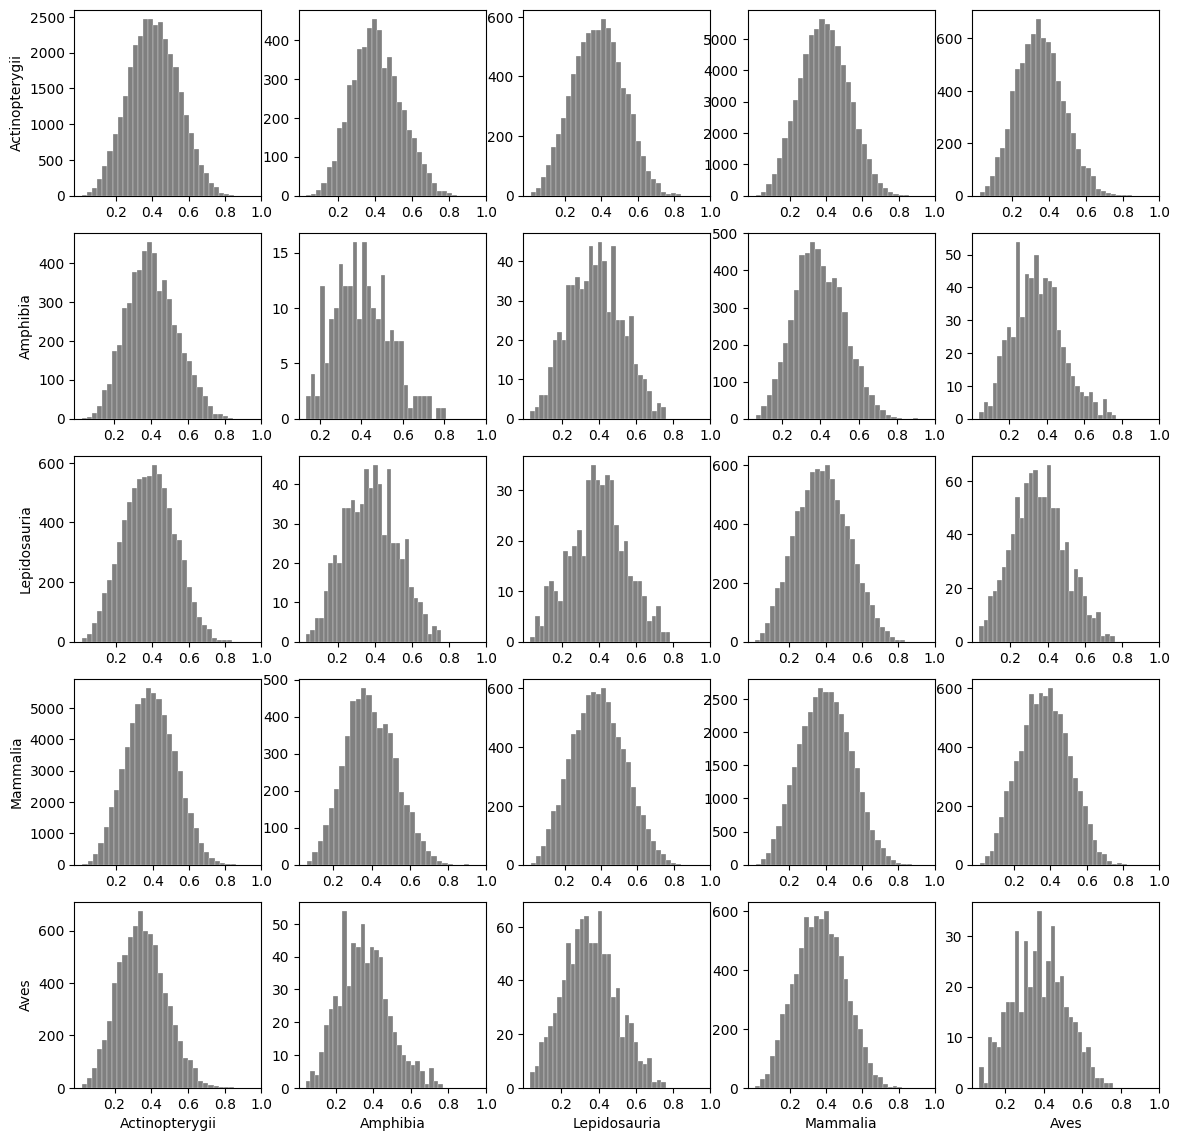

In [249]:
cur_order = ['Actinopterygii', 'Amphibia', 'Lepidosauria', 'Mammalia', 'Aves']


plt.figure(figsize=(14, 14))
for i, cl1 in enumerate(cur_order, 1):
    for j, cl2 in enumerate(cur_order, 1):
        plt.subplot(5, 5, (i-1)*5+j)
        if j % 5 == 1:
            plt.ylabel(cl1)
        if i == 5:
            plt.xlabel(cl2)
        plt.hist(cls_sims[(cls_sims.cls1 == cl1) & (cls_sims.cls2 == cl2)].pp_sims.item(), bins=30, color="gray", linewidth=0.2, edgecolor="white")
        # plt.vlines([cls_sims[(cls_sims.cls1 == cl1) & (cls_sims.cls2 == cl2)].pp_sims.item().mean()], 0, 500, 'red')
        plt.xticks([0.2, .4, .6, .8, 1])
plt.savefig("../pictures/cls_pairwise_similarity_distributions192.pdf", bbox_inches="tight")
plt.show()

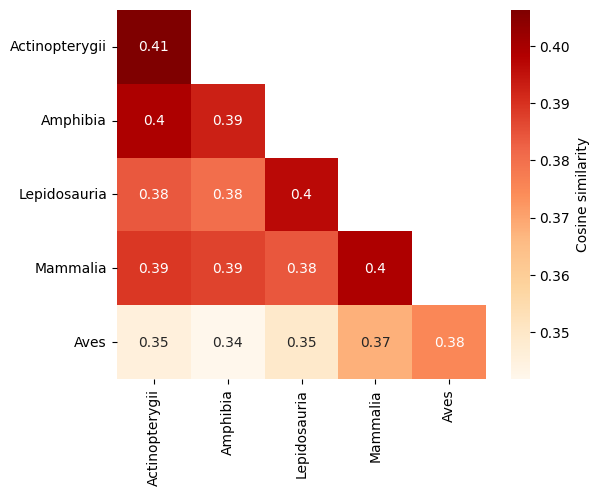

In [250]:
ax = sns.heatmap(
    cls_sims.set_index(["cls1", "cls2"]).pp_sims.apply(np.median).unstack().loc[cur_order, cur_order], 
    annot=True, cmap="OrRd", square=True, mask=np.triu(np.ones(5), 1),
    cbar_kws={"label": "Cosine similarity"}
)

ax.set_xlabel(None)
ax.set_ylabel(None)

plt.savefig("../pictures/cls_pairwise_similarity_median192.pdf", bbox_inches="tight")
plt.show()

## Pairwise species-specific comparison 12

In [169]:
s192to12 = dict()
for sbs192 in possible_sbs192:
    s192to12[sbs192] = sbs192[2:5]

In [170]:
for sbs192 in possible_sbs192:
    sbs12 = sbs192[2:5]
    if sbs12 in sp2mut.columns:
        sp2mut[sbs12] += sp2mut[sbs192]
    else:
        sp2mut[sbs12] = sp2mut[sbs192]

In [171]:
data = []
cls_order = ['Aves', 'Lepidosauria', 'Amphibia', 'Actinopterygii', 'Mammalia']
for _cls in cls_order:
    print(_cls)
    cls_sp = sp2mut.loc[_cls]
    cls_sp_sim = pd.DataFrame(1 - squareform(pdist(cls_sp[possible_sbs12], "cosine")), index=cls_sp.index, columns=cls_sp.index)
    dn = dendrogram(linkage(cls_sp_sim), no_plot=True)
    dn["leaves"]
    data.append(cls_sp.iloc[dn["leaves"]].assign(Class=_cls).reset_index().set_index(["Class", "Species"])[possible_sbs12])

sp2mut_sorted = pd.concat(data)

assert (sp2mut_sorted.sort_index() == sp2mut[possible_sbs12].sort_index()).all().all()

Aves
Lepidosauria
Amphibia
Actinopterygii
Mammalia


In [172]:
sp2mut_sorted.head()

Mut                          A>C       A>G       A>T  C>A  C>G       C>T  \
Class Species                                                              
Aves  Carpodacus_erythrinus  0.0  0.294716  0.000000  0.0  0.0  0.657049   
      Garrulax_canorus       0.0  0.234685  0.000000  0.0  0.0  0.579715   
      Phasianus_colchicus    0.0  0.265323  0.016686  0.0  0.0  0.625710   
      Parus_major            0.0  0.601687  0.010693  0.0  0.0  0.213870   
      Otus_scops             0.0  0.705967  0.014035  0.0  0.0  0.210527   

Mut                               G>A       G>C       G>T       T>A       T>C  \
Class Species                                                                   
Aves  Carpodacus_erythrinus  0.016069  0.003005  0.024038  0.000000  0.005122   
      Garrulax_canorus       0.083144  0.015883  0.021075  0.001765  0.062145   
      Phasianus_colchicus    0.062475  0.000000  0.000000  0.008343  0.017614   
      Parus_major            0.078596  0.020165  0.024442  0.000000  0.041381   
      Otus_scops             0.005423  0.000000  0.053354  0.000000  0.004678   

Mut                               T>G  
Class Species                          
Aves  Carpodacus_erythrinus  0.000000  
      Garrulax_canorus       0.001588  
      Phasianus_colchicus    0.003851  
      Parus_major            0.009166  
      Otus_scops             0.006015

In [173]:
sp_sim = pd.DataFrame(1 - squareform(pdist(sp2mut_sorted, "cosine")), index=sp2mut_sorted.index, columns=sp2mut_sorted.index)
sp_sim.head()

Class                                        Aves                   \
Species                     Carpodacus_erythrinus Garrulax_canorus   
Class Species                                                        
Aves  Carpodacus_erythrinus              1.000000         0.988973   
      Garrulax_canorus                   0.988973         1.000000   
      Phasianus_colchicus                0.996260         0.995226   
      Parus_major                        0.687622         0.671614   
      Otus_scops                         0.653135         0.617755   

Class                                                                   \
Species                     Phasianus_colchicus Parus_major Otus_scops   
Class Species                                                            
Aves  Carpodacus_erythrinus            0.996260    0.687622   0.653135   
      Garrulax_canorus                 0.995226    0.671614   0.617755   
      Phasianus_colchicus              1.000000    0.678756   0.633596   
      Parus_major                      0.678756    1.000000   0.989339   
      Otus_scops                       0.633596    0.989339   1.000000   

Class                                                                         \
Species                     Corvus_corax Lanius_tephronotus Minla_ignotincta   
Class Species                                                                  
Aves  Carpodacus_erythrinus     0.584061           0.545102         0.855615   
      Garrulax_canorus          0.589715           0.565941         0.866598   
      Phasianus_colchicus       0.585732           0.555410         0.852701   
      Parus_major               0.980467           0.952374         0.724712   
      Otus_scops                0.955762           0.915117         0.690152   

Class                                                             ...  \
Species                     Ficedula_hyperythra Cyanopica_cyanus  ...   
Class Species                                                     ...   
Aves  Carpodacus_erythrinus            0.849857         0.758609  ...   
      Garrulax_canorus                 0.822694         0.774056  ...   
      Phasianus_colchicus              0.834384         0.766336  ...   
      Parus_major                      0.929567         0.940119  ...   
      Otus_scops                       0.926470         0.896433  ...   

Class                               Mammalia                        \
Species                     Tamias_sibiricus Sus_scrofa_domesticus   
Class Species                                                        
Aves  Carpodacus_erythrinus         0.909161              0.870981   
      Garrulax_canorus              0.948151              0.918571   
      Phasianus_colchicus           0.933777              0.903852   
      Parus_major                   0.697130              0.495099   
      Otus_scops                    0.618365              0.406441   

Class                                                                   \
Species                     Crocidura_shantungensis Loxodonta_africana   
Class Species                                                            
Aves  Carpodacus_erythrinus                0.882876           0.879547   
      Garrulax_canorus                     0.932596           0.926016   
      Phasianus_colchicus                  0.913275           0.912426   
      Parus_major                          0.529375           0.547582   
      Otus_scops                           0.440978           0.458106   

Class                                                             \
Species                     Thylamys_elegans Ctenomys_sociabilis   
Class Species                                                      
Aves  Carpodacus_erythrinus         0.894384            0.725788   
      Garrulax_canorus              0.942346            0.784135   
      Phasianus_colchicus           0.925994            0.772301   
      Parus_major                   0.549219            0.

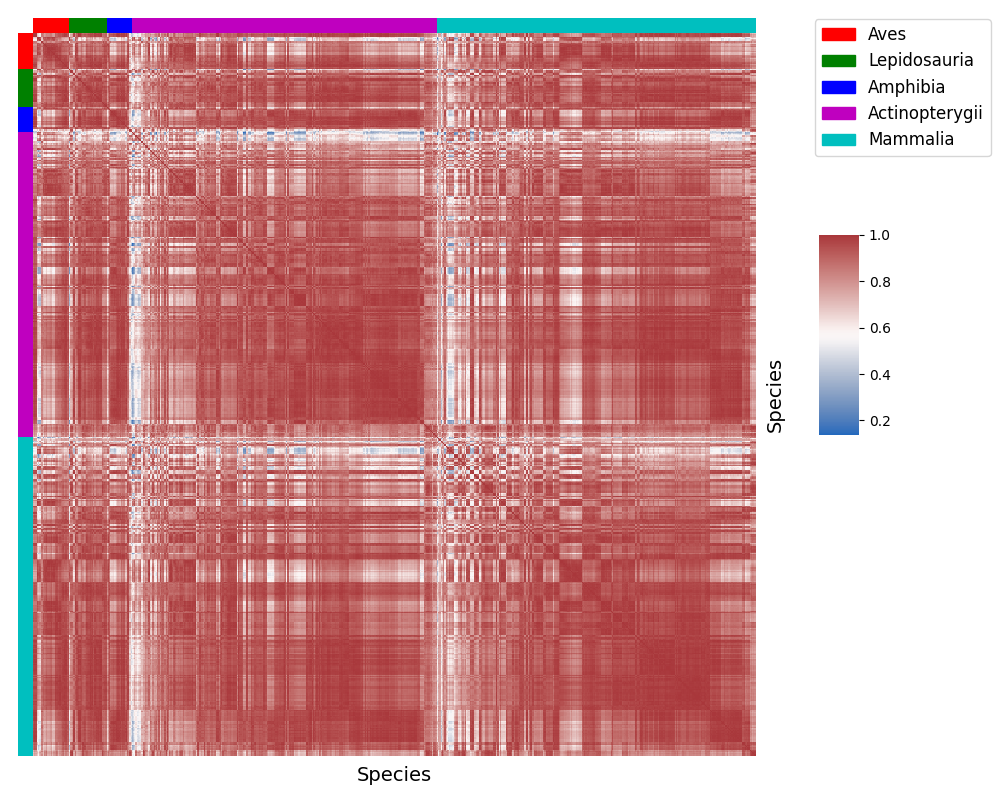

In [32]:
cls_colors = "rgbmc"

g = sns.clustermap(
    sp_sim, 
    cmap="vlag",
    metric="cosine",
    row_cluster=False,
    col_cluster=False,
    row_colors=sp_sim.index.get_level_values(0).map(dict(zip(cls_order, cls_colors))),
    col_colors=sp_sim.index.get_level_values(0).map(dict(zip(cls_order, cls_colors))),
    cbar_pos=(1.03, 0.45, 0.05, 0.25),
    xticklabels=False,
    yticklabels=False,
    figsize=(8, 8),
    dendrogram_ratio=0.01,
    colors_ratio=0.02,
)

g.ax_heatmap.set_xlabel("Species", fontsize=14)
g.ax_heatmap.set_ylabel("Species", fontsize=14)

patches = [mpatches.Patch(color=clr, label=c) for clr, c in zip(cls_colors, cls_order)]

plt.legend(handles=patches, fontsize=12, bbox_to_anchor=(4.5, 2.12))


# plt.savefig("../pictures/species_pairwise_similarity12.png", bbox_inches="tight")
plt.show()

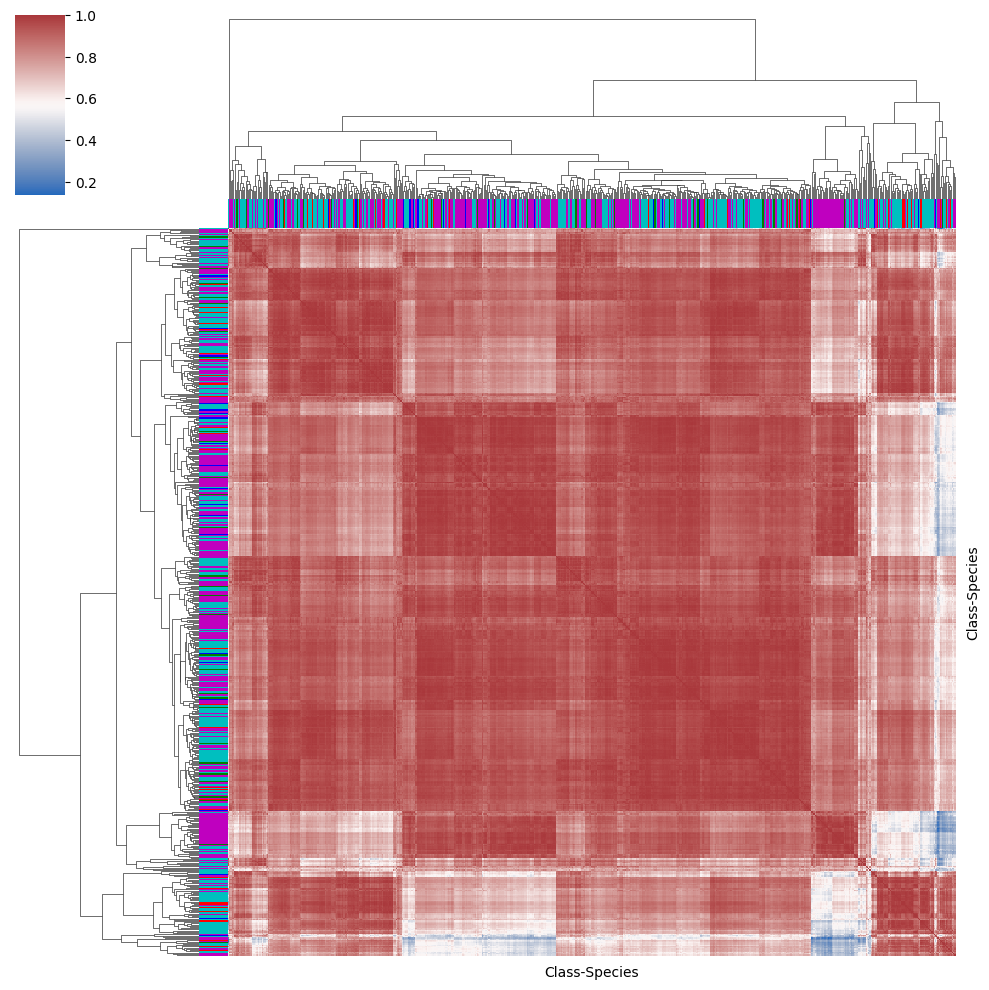

In [33]:
cls_colors = "rgbmc"

sns.clustermap(
    sp_sim, cmap="vlag", 
    row_colors=sp_sim.index.get_level_values(0).map(dict(zip(cls_order, cls_colors))),
    col_colors=sp_sim.index.get_level_values(0).map(dict(zip(cls_order, cls_colors))),
    xticklabels=False,
    yticklabels=False,
);

In [174]:
sp_sim12 = pd.DataFrame(1 - squareform(pdist(sp2mut[possible_sbs12], "cosine")), index=sp2mut.index, columns=sp2mut.index)

In [216]:
data = []
for cl1 in sp_sim12.index.levels[0]:
    for cl2 in sp_sim12.index.levels[0]:
        if cl1 == cl2:
            cur_sims = 1 - pdist(sp2mut.loc[cl1, possible_sbs12], "cosine")
        else:
            cur_sims = 1 - cdist(sp2mut.loc[cl1, possible_sbs12], sp2mut.loc[cl2, possible_sbs12], "cosine").flatten()
        data.append([cl1, cl2, cur_sims])

cls_sims12 = pd.DataFrame(data, columns=["cls1", "cls2", "pp_sims"])

In [217]:
cls_sims12.head()

cls1            cls2  \
0  Actinopterygii  Actinopterygii   
1  Actinopterygii        Amphibia   
2  Actinopterygii            Aves   
3  Actinopterygii    Lepidosauria   
4  Actinopterygii        Mammalia   

                                             pp_sims  
0  [0.36680279164123153, 0.9085712058944126, 0.79...  
1  [0.49480751451324656, 0.9383388757134195, 0.89...  
2  [0.8254341792726552, 0.7468860871416135, 0.737...  
3  [0.8253413555427068, 0.604843453742121, 0.8923...  
4  [0.7682332769880962, 0.6838447145979325, 0.958...

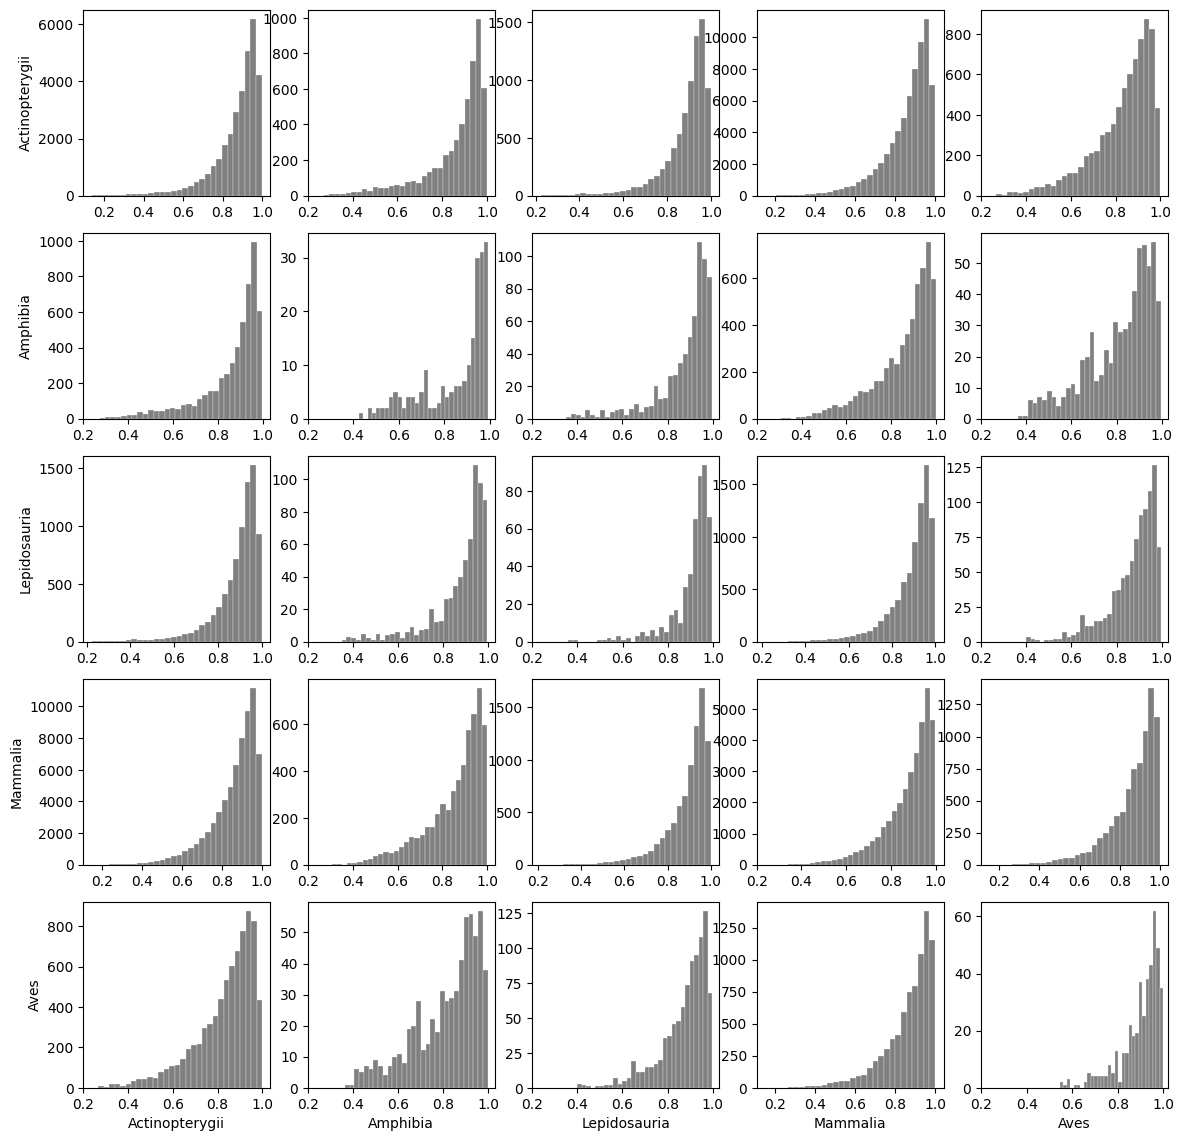

In [218]:
cur_order = ['Actinopterygii', 'Amphibia', 'Lepidosauria', 'Mammalia', 'Aves']


plt.figure(figsize=(14, 14))
for i, cl1 in enumerate(cur_order, 1):
    for j, cl2 in enumerate(cur_order, 1):
        plt.subplot(5, 5, (i-1)*5+j)
        if j % 5 == 1:
            plt.ylabel(cl1)
        if i == 5:
            plt.xlabel(cl2)
        plt.hist(cls_sims12[(cls_sims12.cls1 == cl1) & (cls_sims12.cls2 == cl2)].pp_sims.item(), bins=30, color="gray", linewidth=0.2, edgecolor="white")
        # plt.vlines([cls_sims12[(cls_sims12.cls1 == cl1) & (cls_sims12.cls2 == cl2)].pp_sims.item().mean()], 0, 500, 'red')
        plt.xticks([0.2, .4, .6, .8, 1])
plt.savefig("../pictures/cls_pairwise_similarity_distributions12.pdf", bbox_inches="tight")
plt.show()

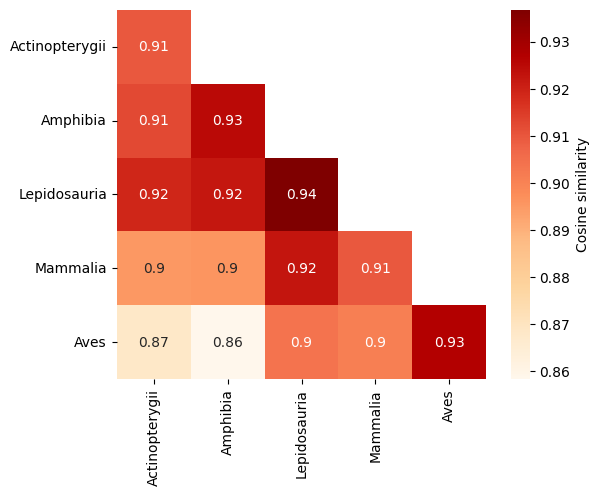

In [219]:
ax = sns.heatmap(
    cls_sims12.set_index(["cls1", "cls2"]).pp_sims.apply(np.median).unstack().loc[cur_order, cur_order], 
    annot=True, cmap="OrRd", square=True, mask=np.triu(np.ones(5), 1),
    cbar_kws={"label": "Cosine similarity"}
)

ax.set_xlabel(None)
ax.set_ylabel(None)

plt.savefig("../pictures/cls_pairwise_similarity_median12.pdf", bbox_inches="tight")
plt.show()

## More reduction: Ts/Tv

In [193]:
sp2mut["Ts"] = 0
sp2mut["Tv"] = 0
for sbs in possible_sbs12:
    if sbs in ["C>T", "A>G", "T>C", "G>A"]:
        sp2mut["Ts"] += sp2mut[sbs]
    else:
        sp2mut["Tv"] += sp2mut[sbs]
sp2mut["TsTv"] = (sp2mut["Ts"] / sp2mut["Tv"]).replace(np.inf, 0.)

In [220]:
sp2mut.iloc[:5, -15:]

Mut                                             A>C       A>G       A>T  \
Class          Species                                                    
Actinopterygii Abbottina_rivularis         0.002968  0.016533  0.028448   
               Acanthopagrus_schlegelii    0.020910  0.287963  0.053395   
               Acheilognathus_macropterus  0.002856  0.218699  0.036559   
               Acheilognathus_rhombeus     0.000000  0.352878  0.000000   
               Acheilognathus_signifer     0.037174  0.171038  0.013995   

Mut                                             C>A       C>G       C>T  \
Class          Species                                                    
Actinopterygii Abbottina_rivularis         0.070996  0.093012  0.576375   
               Acanthopagrus_schlegelii    0.078413  0.031365  0.078413   
               Acheilognathus_macropterus  0.000000  0.011425  0.492023   
               Acheilognathus_rhombeus     0.000000  0.000000  0.457697   
               Acheilognathus_signifer     0.068039  0.069538  0.414855   

Mut                                             G>A       G>C       G>T  \
Class          Species                                                    
Actinopterygii Abbottina_rivularis         0.099628  0.002120  0.054516   
               Acanthopagrus_schlegelii    0.166144  0.040489  0.094521   
               Acheilognathus_macropterus  0.138712  0.003808  0.016675   
               Acheilognathus_rhombeus     0.086285  0.000000  0.000000   
               Acheilognathus_signifer     0.118464  0.010796  0.047889   

Mut                                             T>A       T>C       T>G  \
Class          Species                                                    
Actinopterygii Abbottina_rivularis         0.005018  0.042924  0.007462   
               Acanthopagrus_schlegelii    0.055586  0.036779  0.056022   
               Acheilognathus_macropterus  0.005962  0.068463  0.004818   
               Acheilognathus_rhombeus     0.008337  0.094803  0.000000   
               Acheilognathus_signifer     0.000000  0.041838  0.006373   

Mut                                              Ts        Tv        TsTv  
Class          Species                                                     
Actinopterygii Abbottina_rivularis         0.735460  0.264540    2.780145  
               Acanthopagrus_schlegelii    0.569299  0.430701    1.321798  
               Acheilognathus_macropterus  0.917897  0.082103   11.179814  
               Acheilognathus_rhombeus     0.991663  0.008337  118.948378  
               Acheilognathus_signifer     0.746195  0.253805    2.940037

<AxesSubplot:xlabel='TsTv', ylabel='Class'>

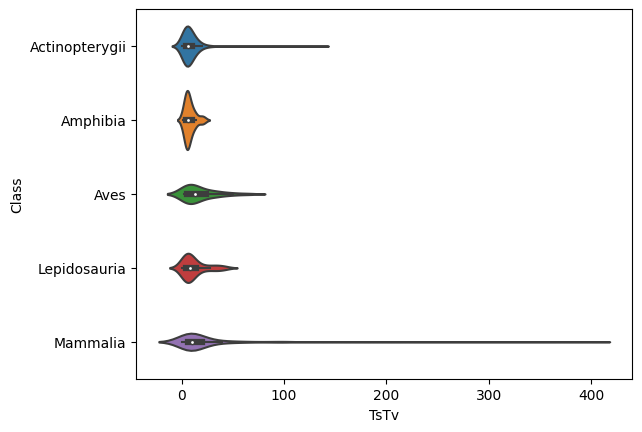

In [196]:
sns.violinplot(data=sp2mut.reset_index().fillna(0), x="TsTv", y="Class")

In [208]:
sp_sim_tstv = pd.DataFrame(squareform(pdist(sp2mut[["TsTv"]])), index=sp2mut.index, columns=sp2mut.index)

In [229]:
data = []
for cl1 in sp_sim_tstv.index.levels[0]:
    for cl2 in sp_sim_tstv.index.levels[0]:
        if cl1 == cl2:
            cur_sims = pdist(sp2mut.loc[cl1, ["TsTv"]])
        else:
            cur_sims = cdist(sp2mut.loc[cl1, ["TsTv"]], sp2mut.loc[cl2, ["TsTv"]]).flatten()
        data.append([cl1, cl2, cur_sims])

cls_sims_tstv = pd.DataFrame(data, columns=["cls1", "cls2", "pp_sims"])

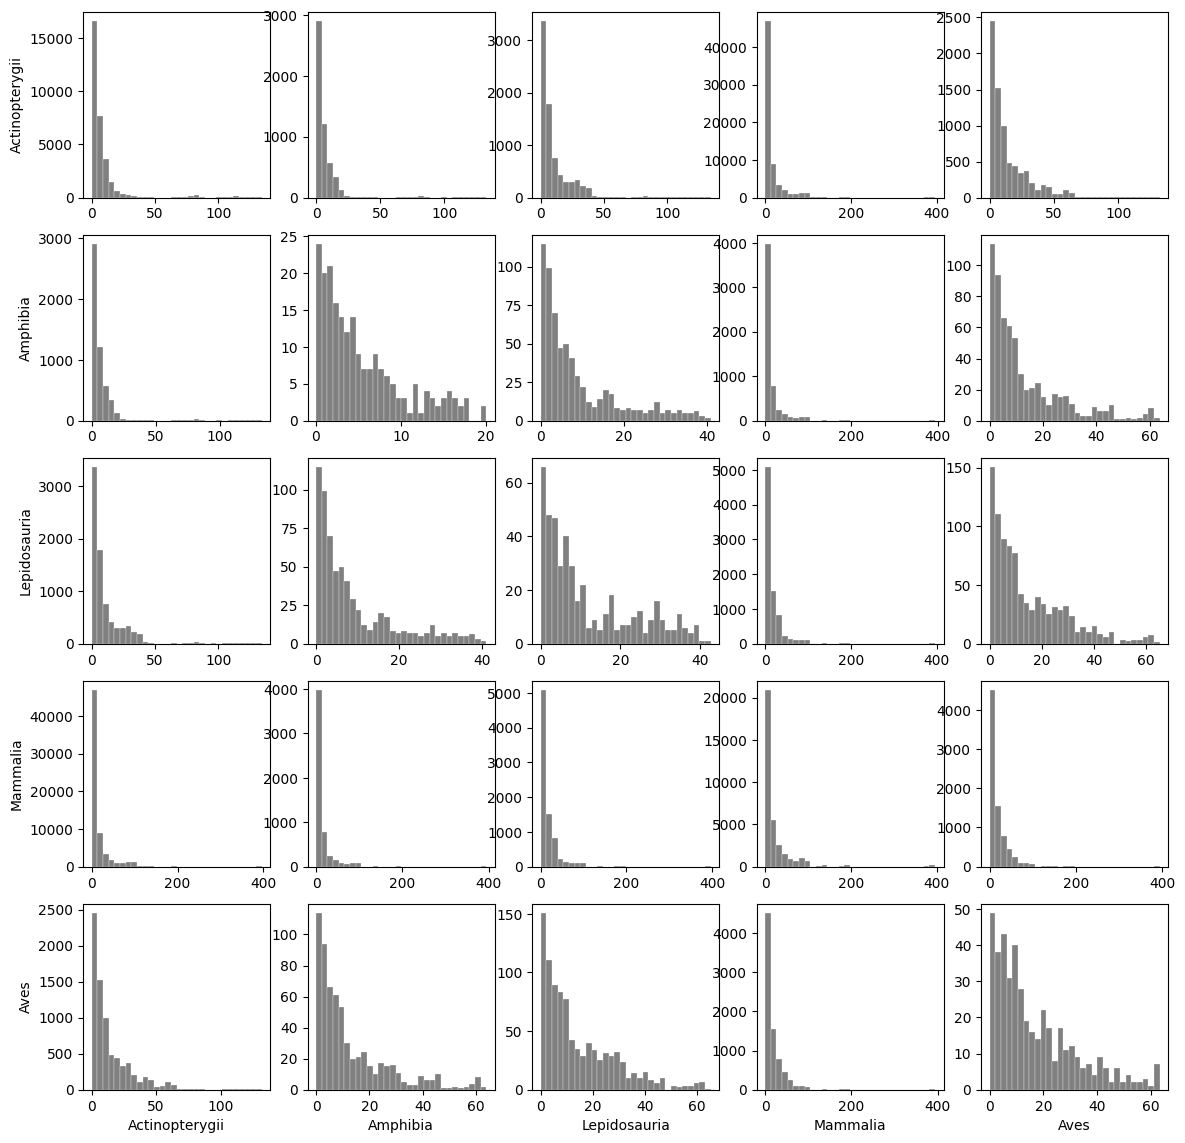

In [246]:
cur_order = ['Actinopterygii', 'Amphibia', 'Lepidosauria', 'Mammalia', 'Aves']


plt.figure(figsize=(14, 14))
for i, cl1 in enumerate(cur_order, 1):
    for j, cl2 in enumerate(cur_order, 1):
        plt.subplot(5, 5, (i-1)*5+j)
        if j % 5 == 1:
            plt.ylabel(cl1)
        if i == 5:
            plt.xlabel(cl2)
        plt.hist(cls_sims_tstv[(cls_sims_tstv.cls1 == cl1) & (cls_sims_tstv.cls2 == cl2)].pp_sims.item(), bins=30, color="gray", linewidth=0.2, edgecolor="white")
        # plt.vlines([cls_sims_tstv[(cls_sims_tstv.cls1 == cl1) & (cls_sims_tstv.cls2 == cl2)].pp_sims.item().mean()], 0, 500, 'red')
        # plt.xticks([0.2, .4, .6, .8, 1])
plt.savefig("../pictures/cls_pairwise_similarity_distributions_tstv.pdf", bbox_inches="tight")
plt.show()

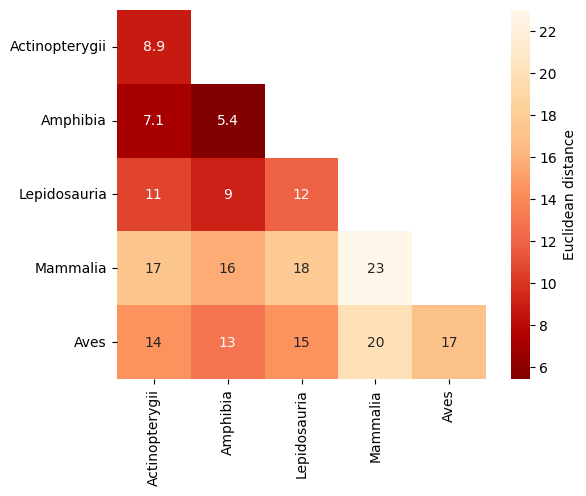

In [245]:
ax = sns.heatmap(
    cls_sims_tstv.set_index(["cls1", "cls2"]).pp_sims.apply(np.mean).unstack().loc[cur_order, cur_order], 
    annot=True, cmap=sns.color_palette("OrRd", 100)[::-1], square=True, mask=np.triu(np.ones(5), 1),
    cbar_kws={"label": "Euclidean distance"}
)

ax.set_xlabel(None)
ax.set_ylabel(None)

plt.savefig("../pictures/cls_pairwise_similarity_median_tstv.pdf", bbox_inches="tight")
plt.show()